# Decision Making Under Uncertainty - Assignment 2

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

## Exercise a.
Derive the product-form solution for the stationary distribution of this Jackson network and determine the stability conditions (consult Lecture on 30 October).

## Exercise b.
Write for this extended system a discrete-event simulation. In order to do this, you might need object-oriented programming.

In [61]:
from scipy import stats
from collections import deque
import heapq
import numpy as np
import matplotlib.pyplot as plt

In [17]:
class Customer :

    def __init__(self, arrivalTime, priority):
        self.arrivalTime = arrivalTime
        self.serviceTime = 0
        self.systemArrivalTime = arrivalTime
        self.priority = priority
        
        # location: holding, needy, content, out, queue_needy
        self.location = 'holding'
        
    def moveTo(self, location, time, newServiceTime):
        
        assert location.lower() in {'holding', 'needy', 'content', 'out', 'queue_needy'},\
            "Not a proper location. Location should be holding, needy, content, out, or queue_needy"
        
        self.location = location.lower()
        self.arrivalTime = time
        self.serviceTime = newServiceTime
        
    def leaveSystem(self):
        self.location = 'out'
        self.serviceTime = -1
        

In [18]:
class Event:

    ARRIVAL = 'ARRIVAL'
    DEPARTURE = 'DEPARTURE'
    
    def __init__(self, typ, time, cust): 
        self.type = typ
        self.time = time
        self.customer = cust
        
    def __lt__(self, other):
        return self.time < other.time
        
    def __str__(self):
        s = ('Arrival', 'Departure')
        return self.type + " of customer " + str(self.customer) + ' at t = ' + str(self.time)


In [19]:
class FES :
    
    def __init__(self):
        self.events = []
        
    def add(self, event):
        heapq.heappush(self.events, event)
        
    def next(self):
        return heapq.heappop(self.events)
    
    def isEmpty(self):
        return len(self.events) == 0
        
    def __str__(self):
        # Note that if you print self.events, it would not appear to be sorted
        # (although they are sorted internally).
        # For this reason we use the function 'sorted'
        s = ''
        sortedEvents = sorted(self.events)
        for e in sortedEvents :
            s += str(e) + '\n'
        return s


In [20]:
class NeedyServer:
    
    def __init__(self, servDist, nrServers=2):
        self.servDist = servDist
        self.nrServers = nrServers
        self.number_of_customers = 0 # Number of customers at this server, not including queue
        
    def __len__(self):
        return self.number_of_customers
        
class ContentServer:
    
    def __init__(self, servDist):
        self.servDist = servDist
        self.number_of_customers = 0
    
    def __len__(self):
        return self.number_of_customers
    

9

In [22]:
class SimulationResults:
    
    def __init__(self):
        self.results = {
            'blocking_probability': {'high': 0,
                                     'low': 0,
                                     'total': 0},
            'waiting_probability_needy': {'high_priority': 0,
                                          'low_priority': 0},
            'mean_time_in_system': {'high_priority': 0,
                                    'low_priority': 0},
            'mean_waiting_time_in_system': {'high_priority': 0,
                                            'low_priority': 0},
            'mean_waiting_time_to_enter_system': {'high_priority': 0,
                                                  'low_priority': 0},
            'mean_queue_length': {'holding_high_priority': 0,
                                  'holding_low_priority': 0,
                                  'needy': 0},
            'utilisation_needy': 0
        }
        self.results = {}
        
        self.number_of_arrivals = {'high': 0,
                                     'low': 0}
        self.number_of_arrivals_waiting = {'high': 0,
                                     'low': 0}
        
        
    def register_arrival(self, priority, waiting=False):
        
        self.number_of_arrivals[priority] += 1

        if waiting:
            self.number_of_arrivals_waiting[priority] += 1
    
    def calculate_blocking_probability(self):
        # number of arrivals that have to wait in holding / total number of arrivals
        
        self.results['blocking_probability'] = {priority : self.number_of_arrivals_waiting[priority] / self.number_of_arrivals[priority]
                                               for priority in ('high','low')}
        self.results['blocking_probability']['total'] = sum(self.number_of_arrivals_waiting.values()) / sum(self.number_of_arrivals.values())
        
        


In [178]:


class Network:
    
    def __init__(self, lambda_L, lambda_H, servDist_needy, nrServers, servDist_content, N, p):
        self.arrDist = stats.expon(scale=1/(lambda_L+lambda_H))
        self.high_priority_probability = lambda_H/(lambda_L+lambda_H) # probability for high
        self.N = N
        self.p = p
        
        # Create servers
        self.NeedyServer = NeedyServer(servDist_needy, nrServers)
        self.ContentServer = ContentServer(servDist_content)
        self.simresults = SimulationResults()
        
    def simulate(self, T):
        
        t = 0 # initialise time
        total_needy_queue=0
        
        fes = FES()                  
        queue_holding_high = deque() # the holding queue for high priority
        queue_holding_low = deque()  # the holding queue for low priority
        queue_needy = deque()        # the queue for needy server
        
        # Generate arrival of the first customer
        u = stats.uniform().rvs()
        
        if u < self.high_priority_probability:
            c0 = Customer(self.arrDist.rvs(), priority='high')
        else:
            c0 = Customer(self.arrDist.rvs(), priority='low')
            
        firstEvent = Event(Event.ARRIVAL, c0.arrivalTime, c0)
        fes.add(firstEvent)                    # schedule first arrival event
        
        
        
        # if number people < N: go to needy queue
        while t < T:
            
#             print("-----------------")
#             print("FES:")
#             print(fes.__str__())
            
            e = fes.next()                      # jump to next event
            t = e.time                          # update the time
            c1 = e.customer                 # customer associated with this event
            
            number_in_system = len(queue_needy) + len(self.NeedyServer) + len(self.ContentServer)

           # print("Needy queue:", len(queue_needy), t)
            total_needy_queue += len(queue_needy)
           # print(total_needy_queue)
            
#             print("At time", t)
#             print("Event", e)
#             print("Number in system:", number_in_system)
#             print(f"of which {len(queue_needy)} in needy queue, {len(self.NeedyServer)} in needy server, {len(self.ContentServer)} in content server")
#             print("Holding queue - high:", queue_holding_high)
#             print("Holding queue - low:", queue_holding_low)
               # print("Needy queue:", queue_needy)
            
            if e.type == 'ARRIVAL':
                if c1.location == 'holding':
                    
                    # Someone arrive
                    
                    if number_in_system <= self.N:
                        # Admit this customer

                        if len(self.NeedyServer) < self.NeedyServer.nrServers:
                            # Admit this customer
                            serviceTime = self.NeedyServer.servDist.rvs()
                            c1.moveTo('needy', t, serviceTime)
                            
                            # Update number of customers at needy server
                            self.NeedyServer.number_of_customers += 1
                            
                            dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                            fes.add(dep)

                        else:
                            # Queue in needy, independent of priority
                            queue_needy.append(c1)
                            c1.moveTo('queue_needy', t, _)

                        self.simresults.register_arrival(priority=c1.priority)
                            
                    else:
                        # else: add to holding queue
                        if c1.priority == 'high':
                            queue_holding_high.append(c1)
                        else:
                            queue_holding_low.append(c1)
                            
                        self.simresults.register_arrival(priority=c1.priority, waiting=True)

                    # Schedule new arrival
                    u = stats.uniform().rvs()

                    if u < self.high_priority_probability:
                        c2 = Customer(self.arrDist.rvs(), priority='high')
                    else:
                        c2 = Customer(self.arrDist.rvs(), priority='low')

                    arrival = Event(Event.ARRIVAL, t + c2.arrivalTime, c2)
                    fes.add(arrival)
                else:
                    raise Exception("ERROR: Arrival from", c1.location)
                    
                
            elif e.type == 'DEPARTURE':
                # Then it's a departure
                
                # Check if departed from needy or from content
                if c1.location == 'content':
                    
                    # Update number of customers at needy server
                    self.ContentServer.number_of_customers -= 1
                    
                    if len(self.NeedyServer) < self.NeedyServer.nrServers:
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c1.moveTo('needy', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                    else:
                        queue_needy.append(c1)
                        c1.moveTo('queue_needy', t, _)
                        
                elif c1.location == 'needy':
                    
                    # Update number of customers at needy server
                    self.NeedyServer.number_of_customers -= 1
                    
                    # Admit person from needy queue, if nonempty
                    if len(queue_needy) > 0:
                        c2 = queue_needy.popleft()
                        
                        serviceTime = self.NeedyServer.servDist.rvs()
                        c2.moveTo('needy', t, serviceTime)

                        # Update number of customers at needy server
                        self.NeedyServer.number_of_customers += 1

                        dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                        fes.add(dep)
                    
                    # Check if leaves or goes to content
                    u = stats.uniform().rvs()

                    if u < self.p:
                        # Go to content
                        serviceTime = self.ContentServer.servDist.rvs()
                        c1.moveTo('content', t, serviceTime)
                        
                        # Update number of customers at needy server
                        self.ContentServer.number_of_customers += 1
                        
                        dep = Event(Event.DEPARTURE, t + serviceTime, c1)
                        fes.add(dep)
                        
                    else:
                        # Leave system
                        c1.leaveSystem() # Set c1.location to out and c1.serviceTime to -1
                        
                        # Admit someone from holding queue
                        if len(queue_holding_high) > 0:
                            c2 = queue_holding_high.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                            
                        elif len(queue_holding_low) > 0:
                            c2 = queue_holding_low.popleft()
                            
                            # Note that we only enter here if a person is admitted from the holding queue
                            if len(self.NeedyServer) < self.NeedyServer.nrServers:
                                serviceTime = self.NeedyServer.servDist.rvs()
                                c2.moveTo('needy', t, serviceTime)

                                # Update number of customers at needy server
                                self.NeedyServer.number_of_customers += 1

                                dep = Event(Event.DEPARTURE, t + serviceTime, c2)
                                fes.add(dep)
                            else:
                                queue_needy.append(c2)
                                c2.moveTo('queue_needy', t, _)
                        else:
                            pass
#                             print(f"No one in holding queue: {len(queue_holding_high)} high and {len(queue_holding_low)} low")
                            # No one waiting in holding queue;
#                             next # Go to next iteration of while loop (i.e. skip everything below this)
                        
                else:
                    raise Exception("ERROR: Departure from", c1.location)
        return total_needy_queue

In [179]:
np.random.seed(1)

mu = 1
delta = 1

servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=1/float(1/delta))

sim = Network(lambda_L=6, lambda_H=4, servDist_needy=servDist_needy, nrServers=2,
              servDist_content=servDist_content, N=25, p=0.4)

q_n = sim.simulate(T=1000)
print(q_n)

2656


In [26]:
print(sim.simresults.number_of_arrivals, sim.simresults.number_of_arrivals_waiting)

sim.simresults.calculate_blocking_probability()
print(sim.simresults.results)


{'high': 3975, 'low': 6017} {'high': 3963, 'low': 6002}
{'blocking_probability': {'high': 0.9969811320754717, 'low': 0.9975070633205917, 'total': 0.9972978382706165}}


## Exercise c.
Use your discrete-event simulation to present performance measures (perhaps probability of blocking for the different customer priority classes, probability of waiting, mean queue length, mean waiting time,...) for the extended system for different values of $\lambda_L$, $\lambda_H$, and $\delta$, and different values of $N$. Elaborate on your findings by creating a comprehensive management report including several sensitivity analyses.

In [72]:
#changing lambda L (and thus fix lambda H)
np.random.seed(1)

mu = 1
delta = 1
servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=1/float(1/delta))
lambda_L=1

runs =9

lambda_L_array = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    sim = Network(lambda_L, lambda_H=4, servDist_needy=servDist_needy, nrServers=2,
              servDist_content=servDist_content, N=25, p=0.4)
    sim.simulate(T=100)

    sim.simresults.calculate_blocking_probability()
    print("Probability for lambda_L equal to", lambda_L)
    print("Maximum probability: ", sim.simresults.results['blocking_probability']['low'])
    print("")
    
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    lambda_L_array[i] = lambda_L
    lambda_L += 1
    

Probability for lambda_L equal to 1
Maximum probability:  0.9813278008298755

Probability for lambda_L equal to 2
Maximum probability:  0.9949899799599199

Probability for lambda_L equal to 3
Maximum probability:  0.9895561357702349

Probability for lambda_L equal to 4
Maximum probability:  0.9921875

Probability for lambda_L equal to 5
Maximum probability:  0.9952922714790113

Probability for lambda_L equal to 6
Maximum probability:  0.9923384410393071

Probability for lambda_L equal to 7
Maximum probability:  0.995427264932838

Probability for lambda_L equal to 8
Maximum probability:  0.995417515274949

Probability for lambda_L equal to 9
Maximum probability:  0.9955595026642984



In [84]:
#changing lambda H (and thus fix lambda L)
np.random.seed(1)

mu = 1
delta = 1
servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=1/float(1/delta))
lambda_H=1
lambda_L=6

runs =10

lambda_H_array = np.zeros(runs)
probabilities_high = np.zeros(runs)
lambda_L_array = np.zeros(runs)
probabilities_low = np.zeros(runs)

for i in range(runs):
    sim = Network(lambda_L, lambda_H, servDist_needy=servDist_needy, nrServers=2,
              servDist_content=servDist_content, N=25, p=0.4)
    sim.simulate(T=100)

    sim.simresults.calculate_blocking_probability()
    print("Probability for lambda_H equal to", lambda_H)
    print("Maximum probability high: ", sim.simresults.results['blocking_probability']['high'])
    print("")
    
    probabilities_high[i] = sim.simresults.results['blocking_probability']['high']
    probabilities_low[i] = sim.simresults.results['blocking_probability']['low']
    lambda_H_array[i] = lambda_H
    lambda_H += 1

Probability for lambda_H equal to 1
Maximum probability high:  0.948051948051948

Probability for lambda_H equal to 2
Maximum probability high:  0.9423076923076923

Probability for lambda_H equal to 3
Maximum probability high:  0.9646643109540636

Probability for lambda_H equal to 4
Maximum probability high:  0.9761904761904762

Probability for lambda_H equal to 5
Maximum probability high:  0.970954356846473

Probability for lambda_H equal to 6
Maximum probability high:  0.9753521126760564

Probability for lambda_H equal to 7
Maximum probability high:  0.981159420289855

Probability for lambda_H equal to 8
Maximum probability high:  0.9790575916230366

Probability for lambda_H equal to 9
Maximum probability high:  0.9811946902654868

Probability for lambda_H equal to 10
Maximum probability high:  0.9790076335877863



Text(0.5, 1.0, 'Change in probability as $\\lambda_L$ changes')

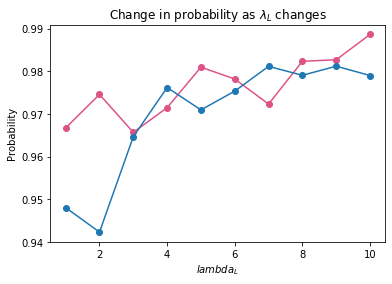

In [87]:
plt.plot(lambda_H_array, probabilities_low, marker='o', color='#de5285')
plt.plot(lambda_H_array, probabilities_high, marker='o')
plt.xlabel('$lambda_L$')
plt.ylabel('Probability')
plt.title('Change in probability as $\lambda_L$ changes')

Text(0.5, 1.0, 'Change in probability as $\\lambda_H$ changes')

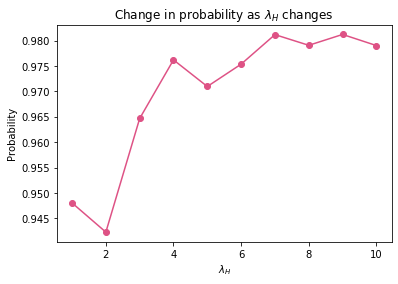

In [88]:
plt.plot(lambda_H_array, probabilities_high, marker='o', color='#de5285')
plt.xlabel('$\lambda_H$')
plt.ylabel('Probability')
plt.title('Change in probability as $\lambda_H$ changes')

In [184]:
#changing p  (comparing the needy queue length)
np.random.seed(1)

mu = 1
delta = 1
servDist_needy = stats.expon(scale=float(1/mu))
servDist_content = stats.expon(scale=1/float(1/delta))
p = 0.1
lambda_L=5
lambda_H=5
nrServers=2
N=25
servDist_needy=servDist_needy
servDist_content=servDist_content

runs = 9

p_array = np.zeros(runs)
queuelength = np.zeros(runs)
T=100

for i in range(runs):
    sim = Network(lambda_L, lambda_H, servDist_needy, nrServers,
              servDist_content, N, p)
    q_n = sim.simulate(T)

    #sim.simresults.calculate_mean_queue_length()
    print("Probability of not leaving system equal to", p)
    print("Mean queue length: ", q_n / (T *13))
    print("")
    
    queuelength[i] = q_n / (T *13)
    p_array[i] = p
    p += .1

Probability of not leaving system equal to 0.1
Mean queue length:  22.113076923076925

Probability of not leaving system equal to 0.2
Mean queue length:  22.61

Probability of not leaving system equal to 0.30000000000000004
Mean queue length:  23.142307692307693

Probability of not leaving system equal to 0.4
Mean queue length:  22.70769230769231

Probability of not leaving system equal to 0.5
Mean queue length:  22.65

Probability of not leaving system equal to 0.6
Mean queue length:  22.806923076923077

Probability of not leaving system equal to 0.7
Mean queue length:  21.803846153846155

Probability of not leaving system equal to 0.7999999999999999
Mean queue length:  22.55846153846154

Probability of not leaving system equal to 0.8999999999999999
Mean queue length:  23.043076923076924



Text(0.5, 1.0, 'Change in probability as $\\lambda_H$ changes')

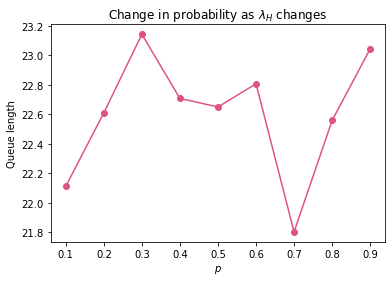

In [186]:
plt.plot(p_array, queuelength, marker='o', color='#de5285')
plt.xlabel('$p$')
plt.ylabel('Queue length')
plt.title('Change in probability as $\lambda_H$ changes')

## Exercise d.
Investigate the didderence in performance between the original system ($N = 1$) and the extended system (finite $N$). For instance, how fast does the behavior of the extended system mimic the original system behavior as $N$ increases?